# First Checkpoint - 09.12.2022

Add all dependencies

In [1]:
import string
from dataclasses import dataclass

import pandas as pd
import numpy as np

from pathlib import Path
import wta.helpers
from wta.main import run

import matplotlib.pyplot as plt

from estimate_start_times.concurrency_oracle import HeuristicsConcurrencyOracle
from estimate_start_times.config import Configuration

Define `EventLogIDs` data class

In [2]:
@dataclass
class EventLogIDs:
    case: str = 'case_id'
    activity: str = 'Activity'
    enabled_time: str = 'enabled_time'
    start_time: str = 'start_time'
    end_time: str = 'end_time'
    resource: str = 'Resource'
    log_id: str = 'source_log'
    cluster_id: str = 'cluster_id'

Function to read event log from csv

In [3]:
def read_event_log(log_path: str, log_ids: EventLogIDs) -> pd.DataFrame:
    event_log = pd.read_csv(log_path)
    event_log[log_ids.start_time] = pd.to_datetime(event_log[log_ids.start_time], utc=True)
    event_log[log_ids.end_time] = pd.to_datetime(event_log[log_ids.end_time], utc=True)
    event_log[log_ids.resource].fillna("NOT_SET", inplace=True)
    event_log[log_ids.resource] = event_log[log_ids.resource].astype("string")
    return event_log

Add enablement times function

In [4]:
def add_enablement_times(event_log: pd.DataFrame, log_ids: EventLogIDs):
    # Set up default configuration
    configuration = Configuration(
        log_ids=log_ids,  # Custom the column IDs with this parameter
        consider_start_times=True  # Consider real parallelism if the start times are available
    )
    # Instantiate desired concurrency oracle
    concurrency_oracle = HeuristicsConcurrencyOracle(event_log, configuration)
    # Add enablement times to the event log
    concurrency_oracle.add_enabled_times(event_log)

Get Activity mapping

In [5]:
def get_activity_mapping(event_log: pd.DataFrame, log_ids: EventLogIDs):
    characters = string.printable
    activities = set(event_log[log_ids.activity].unique())
    # Check if there are enough characters to map all activities
    if len(activities) > len(characters):
        raise RuntimeError(
            "Not enough characters ({}) to map all activities ({}) when clustering by activity sequence!".format(
                len(characters),
                len(activities)
            )
        )
    # Return activity-character mapping
    return {activity: characters[index] for index, activity in enumerate(activities)}


Function to cluster traces

In [6]:
def cluster_traces(event_log: pd.DataFrame, log_ids: EventLogIDs):
    # Get the mapping from activity to character
    mapping = get_activity_mapping(event_log, log_ids)
    # Define mapping from sequence to case IDs
    clusters = {}
    # For each case, map the activities to character sequence
    for (case_id, log_id), events in event_log.groupby([log_ids.case, log_ids.log_id]):
        sorted_events = events.sort_values([log_ids.end_time, log_ids.start_time])
        activity_sequence = "".join([mapping[activity] for activity in sorted_events[log_ids.activity]])
        if activity_sequence in clusters:
            if log_id in clusters[activity_sequence]:
                clusters[activity_sequence][log_id] += [case_id]
            else:
                clusters[activity_sequence][log_id] = [case_id]
        else:
            clusters[activity_sequence] = {log_id: [case_id]}
    # Set cluster ID column for each cluster
    cluster_id = 0
    for cluster in clusters:
        for log_id in clusters[cluster]:
            event_log.loc[
                (event_log[log_ids.log_id] == log_id) & (event_log[log_ids.case].isin(clusters[cluster][log_id])),
                log_ids.cluster_id
            ] = cluster_id
        cluster_id += 1


# Main pipeline

In [7]:
default_log_ids = EventLogIDs()
event_log_1_path = "data/Loan_Application_Estonia.csv.gz"
event_log_2_path = "data/Loan_Application_Spain.csv.gz"

event_log_1 = read_event_log(event_log_1_path, default_log_ids)
event_log_2 = read_event_log(event_log_2_path, default_log_ids)

# Retain only the columns I'm interested on
event_log_1 = event_log_1[[
    default_log_ids.case,
    default_log_ids.activity,
    default_log_ids.start_time,
    default_log_ids.end_time,
    default_log_ids.resource
]]
event_log_2 = event_log_2[[
    default_log_ids.case,
    default_log_ids.activity,
    default_log_ids.start_time,
    default_log_ids.end_time,
    default_log_ids.resource
]]

Compute enablement time for each log

In [8]:
add_enablement_times(event_log_1, default_log_ids)
add_enablement_times(event_log_2, default_log_ids)

c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:147: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, trace) in event_log.groupby([config.log_ids.case]):
c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:45: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (case_id, trace) in event_log.groupby([self.log_ids.case]):
c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:147: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby wi

Add extra column to identify the log

In [9]:
event_log_1[default_log_ids.log_id] = 'log_1'
event_log_2[default_log_ids.log_id] = 'log_2'

Concatenate event logs

In [10]:
merged_event_log = pd.concat([event_log_1, event_log_2], ignore_index=True)

Cluster their traces

In [11]:
cluster_traces(merged_event_log, default_log_ids)

Compare and analyze

In [12]:
filter_column = default_log_ids.log_id
filter_value = 'log_1'

filtered_event_log = merged_event_log[ merged_event_log[filter_column]== filter_value ]


In [13]:
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
unique_activity_counter = 0
activity_map = {}
character_map = {}
all_traces = []
activity_count = 0
trace_count = 0
unique_activities = {}
unique_traces = {}
for cluster_id, cluster_events in filtered_event_log.groupby(default_log_ids.cluster_id):
    for source_id, events in cluster_events.groupby(default_log_ids.log_id):
        for case_id, activities in events.groupby(default_log_ids.case):
            trace_count += 1
            current_trace = ''
            is_first = True
            total_process_time = 0
            cycle_time_start = None
            cycle_time_end = None
            for index, row in activities.iterrows():
                activity_count += 1
                if is_first:
                    is_first = False
                    cycle_time_start = row[default_log_ids.start_time]
                cycle_time_end = row[default_log_ids.end_time]

                if row[default_log_ids.activity] not in activity_map.keys():
                    activity_map[row[default_log_ids.activity]] = alphabet[unique_activity_counter]
                    character_map[alphabet[unique_activity_counter]] = row[default_log_ids.activity]
                    current_trace += alphabet[unique_activity_counter]

                    unique_activity_counter += 1
                else:
                    current_trace += activity_map[row[default_log_ids.activity]]

                process_time = row[default_log_ids.end_time] - row[default_log_ids.start_time]
                total_process_time = process_time if total_process_time == 0 else process_time + total_process_time

                if row[default_log_ids.activity] not in unique_activities.keys():
                    unique_activities[row[default_log_ids.activity]] = {
                        "count": 1,
                        "total_process_time": process_time
                    }
                else:
                    unique_activities[row[default_log_ids.activity]]["total_process_time"] += process_time
                    unique_activities[row[default_log_ids.activity]]["count"] += 1

            if current_trace not in unique_traces.keys():
                unique_traces[current_trace] = {
                    "count": 1,
                    "total_cycle_time": cycle_time_end - cycle_time_start,
                    "total_process_time": total_process_time
                }
            else:
                unique_traces[current_trace]["count"] += 1
                unique_traces[current_trace]["total_cycle_time"] += cycle_time_end-cycle_time_start
                unique_traces[current_trace]["total_process_time"] += process_time

for trace in unique_traces.keys():
    unique_traces[trace]["average_cycle_time"] = unique_traces[trace]["total_cycle_time"] / unique_traces[trace]["count"]
    unique_traces[trace]["average_process_time"] = unique_traces[trace]["total_process_time"] / unique_traces[trace]["count"]
    unique_traces[trace]["cycle_time_efficiency"] = unique_traces[trace]["total_cycle_time"] / unique_traces[trace]["total_process_time"]
    unique_traces[trace]["frequency"] = unique_traces[trace]["count"] / trace_count

for activity in unique_activities.keys():
    unique_activities[activity]["average_process_time"] = unique_activities[activity]["total_process_time"] / unique_activities[activity]["count"]



# Waiting times

In [19]:
logs_ids = wta.EventLogIDs(
    start_time='start_time',
    end_time='end_time',
    case='case_id',
    activity='Activity',
    resource='Resource'
)

wt_analysis1 = run(log_path=Path('.\data\Loan_Application_Estonia.csv.gz'), log_ids=logs_ids)
wt_analysis2 = run(log_path=Path('.\data\Loan_Application_Spain.csv.gz'), log_ids=logs_ids)
wt_analysis = run(log_path=None, log=filtered_event_log, log_ids=logs_ids, group_results=False)

c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:147: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, trace) in event_log.groupby([config.log_ids.case]):
c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:45: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (case_id, trace) in event_log.groupby([self.log_ids.case]):



--------------------------------------------------------------------------------
Batch Analysis
--------------------------------------------------------------------------------


C:\Users\mirjalal\PycharmProjects\ava-core\venv\lib\site-packages\batch_processing_discovery\discovery.py:89: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for batch_id, batch_events in event_log[~pd.isna(event_log[log_ids.batch_id])].groupby([log_ids.batch_id]):
C:\Users\mirjalal\PycharmProjects\ava-core\venv\lib\site-packages\wta\helpers.py:259: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (batch_key, batch_instance) in batch_events.groupby([log_ids.batch_id]):


Elapsed time: 3.2525601387023926 seconds
--------------------------------------------------------------------------------


c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:147: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, trace) in event_log.groupby([config.log_ids.case]):



--------------------------------------------------------------------------------
Activity Transitions Analysis
--------------------------------------------------------------------------------
Parallel run: True


Waiting for tasks to finish: 100%|██████████| 1000/1000 [00:00<00:00, 37828.10it/s]


Elapsed time: 135.3665850162506 seconds
--------------------------------------------------------------------------------


c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:147: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, trace) in event_log.groupby([config.log_ids.case]):
c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:45: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (case_id, trace) in event_log.groupby([self.log_ids.case]):



--------------------------------------------------------------------------------
Batch Analysis
--------------------------------------------------------------------------------


C:\Users\mirjalal\PycharmProjects\ava-core\venv\lib\site-packages\batch_processing_discovery\discovery.py:89: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for batch_id, batch_events in event_log[~pd.isna(event_log[log_ids.batch_id])].groupby([log_ids.batch_id]):
C:\Users\mirjalal\PycharmProjects\ava-core\venv\lib\site-packages\wta\helpers.py:259: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (batch_key, batch_instance) in batch_events.groupby([log_ids.batch_id]):


Elapsed time: 4.27675199508667 seconds
--------------------------------------------------------------------------------


c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:147: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, trace) in event_log.groupby([config.log_ids.case]):



--------------------------------------------------------------------------------
Activity Transitions Analysis
--------------------------------------------------------------------------------
Parallel run: True


Waiting for tasks to finish: 100%|██████████| 1000/1000 [00:00<00:00, 39917.62it/s]


Elapsed time: 170.01503562927246 seconds
--------------------------------------------------------------------------------


C:\Users\mirjalal\PycharmProjects\ava-core\venv\lib\site-packages\wta\main.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log.sort_values(by=[log_ids.end_time, log_ids.start_time, log_ids.activity], inplace=True)
c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:147: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, trace) in event_log.groupby([config.log_ids.case]):
c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:45: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating ove


--------------------------------------------------------------------------------
Batch Analysis
--------------------------------------------------------------------------------


c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_log[self.log_ids.enabled_time] = pd.to_datetime(event_log[self.log_ids.enabled_time], utc=True)
C:\Users\mirjalal\PycharmProjects\ava-core\venv\lib\site-packages\batch_processing_discovery\discovery.py:89: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for batch_id, batch_events in event_log[~pd.isna(event_log[log_ids.batch_id])].groupby([log_ids.batch_id]):


Elapsed time: 2.2119221687316895 seconds
--------------------------------------------------------------------------------


C:\Users\mirjalal\PycharmProjects\ava-core\venv\lib\site-packages\wta\helpers.py:259: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (batch_key, batch_instance) in batch_events.groupby([log_ids.batch_id]):
c:\users\mirjalal\pycharmprojects\start-time-estimator\src\estimate_start_times\concurrency_oracle.py:147: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, trace) in event_log.groupby([config.log_ids.case]):



--------------------------------------------------------------------------------
Activity Transitions Analysis
--------------------------------------------------------------------------------
Parallel run: True


Waiting for tasks to finish: 100%|██████████| 1000/1000 [00:00<00:00, 58569.85it/s]


Elapsed time: 105.57841229438782 seconds
--------------------------------------------------------------------------------


In [18]:
waiting_time = {}
total_transition_number = wt_analysis1.num_transition_instances + wt_analysis2.num_transition_instances

waiting_time['total'] = wt_analysis1.total_wt + wt_analysis2.total_wt
waiting_time['average'] = waiting_time['total'] / total_transition_number

waiting_time['batching'] = wt_analysis1.total_batching_wt + wt_analysis2.total_batching_wt
waiting_time['contention'] = wt_analysis1.total_contention_wt + wt_analysis2.total_contention_wt
waiting_time['extraneous'] = wt_analysis1.total_extraneous_wt + wt_analysis2.total_extraneous_wt
waiting_time['prioritization'] = wt_analysis1.total_prioritization_wt + wt_analysis2.total_prioritization_wt
waiting_time['unavailability'] = wt_analysis1.total_unavailability_wt + wt_analysis2.total_unavailability_wt

waiting_time['average_batching'] = waiting_time['batching'] / total_transition_number
waiting_time['average_contention'] = waiting_time['contention'] / total_transition_number
waiting_time['average_extraneous'] = waiting_time['extraneous'] / total_transition_number
waiting_time['average_prioritization'] = waiting_time['prioritization'] / total_transition_number
waiting_time['average_unavailability'] = waiting_time['unavailability'] / total_transition_number


AttributeError: 'DataFrame' object has no attribute 'num_transition_instances'

Working working

In [ ]:
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
count = 0
unique_activities = {}
all_traces = {}
all_cycle_times = {}
all_process_times = {}

for cluster_id, cluster_events in merged_event_log.groupby(default_log_ids.cluster_id):
    # Compare traces of both logs within the same cluster
    unique_traces = {}
    for source_id, events in cluster_events.groupby(default_log_ids.log_id):
        traces = []
        for case_id, activities in events.groupby(default_log_ids.case):
            trace = ""
            cycle_time = 0
            cycle_time_end = 0
            process_time = 0
            for activity in activities.values:
                if cycle_time == 0:
                    cycle_time = activity[2]
                cycle_time_end = activity[3]

                process_time = activity[3] - activity[2]

                if activity[1] not in all_process_times.keys():
                    all_process_times[activity[1]] = {
                        "total_process_time": process_time,
                        "count": 1
                    }
                else:
                    current_process_time = all_process_times[activity[1]]
                    current_process_time["total_process_time"] += process_time
                    current_process_time["count"] += 1
                    all_process_times[activity[1]] = current_process_time

                if activity[1] not in unique_activities.keys():
                    unique_activities[activity[1]] = alphabet[count]
                    count += 1
                trace += unique_activities[activity[1]]
            cycle_time = cycle_time_end - cycle_time

            if trace not in all_cycle_times.keys():
                all_cycle_times[trace] = {
                    "total_cycle_time": cycle_time,
                    "total_process_time": process_time,
                    "count": 1
                }
            else:
                current_cycle_time = all_cycle_times[trace]

                current_cycle_time["total_cycle_time"] += cycle_time
                current_cycle_time["total_process_time"] += process_time
                current_cycle_time["count"] += 1

                all_cycle_times[trace] = current_cycle_time

            if trace not in traces:
                traces.append(trace)
        unique_traces[source_id] = traces
    all_traces[cluster_id] = unique_traces

    arr = []

    for key in unique_traces.keys():
        for trace in unique_traces[key]:
            temp_arr = []
            for activity in trace:
                temp_arr.append(alphabet.index(activity))
            arr.append(temp_arr)



In [19]:
unique_activities_mapping = {}
for key in unique_activities.keys():
    print(f"{unique_activities[key]}: {key}")
    unique_activities_mapping[unique_activities[key]] = key


{'count': 2000, 'total_process_time': Timedelta('320 days 11:04:21.354000'), 'average_process_time': Timedelta('0 days 03:50:43.930677')}:  Check  application  form completeness


TypeError: unhashable type: 'dict'

In [ ]:
for key in all_traces.keys():
    print(f"{int(key)}. cluster:")
    for source_id in all_traces[key]:
        print(f"{source_id}: {all_traces[key][source_id]}")
    print("--------------------")



In [ ]:
all_cycle_times_arr = []
for trace in all_cycle_times.keys():
    all_cycle_times_arr.append([
        trace, all_cycle_times[trace]['total_cycle_time'], all_cycle_times[trace]['total_process_time'], all_cycle_times[trace]['count'], all_cycle_times[trace]['total_cycle_time']/all_cycle_times[trace]['count'], all_cycle_times[trace]['total_process_time']/all_cycle_times[trace]['count'], all_cycle_times[trace]['total_process_time']/all_cycle_times[trace]['total_cycle_time']
    ])
    print(f"{trace}: ")
    print(f"Total Cycle Time: {all_cycle_times[trace]['total_cycle_time']}")
    print(f"Total Process Time: {all_cycle_times[trace]['total_process_time']}")
    print(f"Total number of traces: {all_cycle_times[trace]['count']}")
    print(f"Average Cycle Time: {all_cycle_times[trace]['total_cycle_time']/all_cycle_times[trace]['count']}")
    print(f"Average Process Time: {all_cycle_times[trace]['total_process_time']/all_cycle_times[trace]['count']}")
    print(f"Cycle-time-efficiency: {all_cycle_times[trace]['total_process_time']/all_cycle_times[trace]['total_cycle_time']}")
    print("------------")

all_cycle_times_df = pd.DataFrame(
    np.array(all_cycle_times_arr),
    columns=['Variant', 'Total CT', 'Total PT', 'Frequency', 'Average CT', 'Average PT', 'CTE']
)

In [159]:
all_process_times_arr = []
for activity in all_process_times.keys():
    all_process_times_arr.append([
        activity, all_process_times[activity]['total_process_time'], all_process_times[activity]['count'], all_process_times[activity]['total_process_time']/all_process_times[activity]['count']
    ])

    print(f"{activity}: ")
    print(f"Total Process Time: {all_process_times[activity]['total_process_time']}")
    print(f"Total number of activity: {all_process_times[activity]['count']}")
    print(f"Average Process Time: {all_process_times[activity]['total_process_time']/all_process_times[activity]['count']}")
    print("------------")

all_process_times_df = pd.DataFrame(
    all_process_times_arr,
    columns=['activity', 'Total PT', 'Frequency', 'Average PT']
)

 Check  application  form completeness: 
Total Process Time: 320 days 11:04:21.354000
Total number of activity: 2000
Average Process Time: 0 days 03:50:43.930677
------------
 AML Check: 
Total Process Time: 183 days 21:13:38.800000
Total number of activity: 2000
Average Process Time: 0 days 02:12:23.809400
------------
 Assess loan risk: 
Total Process Time: 259 days 03:44:15.267000
Total number of activity: 2000
Average Process Time: 0 days 03:06:35.527633500
------------
 Design loan offer: 
Total Process Time: 78 days 23:36:01.011000
Total number of activity: 990
Average Process Time: 0 days 01:54:53.091930303
------------
 Approve Loan Offer: 
Total Process Time: 74 days 11:06:08.844000
Total number of activity: 990
Average Process Time: 0 days 01:48:18.554387878
------------
 Prepare acceptance pack: 
Total Process Time: 0 days 00:00:00
Total number of activity: 990
Average Process Time: 0 days 00:00:00
------------
 Prepare home insurance quote: 
Total Process Time: 115 days 03:

In [27]:
def find_by_source_and_target(report, source, target):
    for transition in report:
        if transition['source_activity'] == source and transition['target_activity'] == target:
            return transition

In [53]:
from IPython.display import Image
import pydot

report = wt_analysis1.report

trace = list(unique_traces.keys())[3]

# Create the graph object
avg_pt_wt_graph = pydot.Dot(graph_type='graph', rankdir='LR')
total_pt_wt_graph = pydot.Dot(graph_type='graph', rankdir='LR')
avg_freq_graph = pydot.Dot(graph_type='graph', rankdir='LR')
total_freq_graph = pydot.Dot(graph_type='graph', rankdir='LR')

nodes = {event: pydot.Node(event) for event in trace}

for node in nodes.values():
    avg_pt_wt_graph.add_node(node)

for i in range(len(trace)-1):
    transition = find_by_source_and_target(report, character_map[trace[i]], character_map[trace[i+1]])

    avg_pt_wt_edge = pydot.Edge(nodes[trace[i]], nodes[trace[i+1]])
    total_pt_wt_edge = pydot.Edge(nodes[trace[i]], nodes[trace[i+1]])
    avg_freq_edge = pydot.Edge(nodes[trace[i]], nodes[trace[i+1]])
    total_freq_edge = pydot.Edge(nodes[trace[i]], nodes[trace[i+1]])

    avg_pt_wt_edge.set_dir('forward')
    total_pt_wt_edge.set_dir('forward')
    avg_freq_edge.set_dir('forward')
    total_freq_edge.set_dir('forward')

    avg_pt_wt_edge.set_label(f"{round(transition['total_wt']/transition['total_freq'], 2)}")
    total_pt_wt_edge.set_label(f"{round(transition['total_wt'], 2)}")
    avg_freq_edge.set_label(f"{round(transition['case_freq'], 2)}")
    total_freq_edge.set_label(f"{round(transition['total_freq'], 2)}")

    avg_pt_wt_graph.add_edge(avg_pt_wt_edge)
    total_pt_wt_graph.add_edge(total_pt_wt_edge)
    avg_freq_graph.add_edge(avg_freq_edge)
    total_freq_graph.add_edge(total_freq_edge)



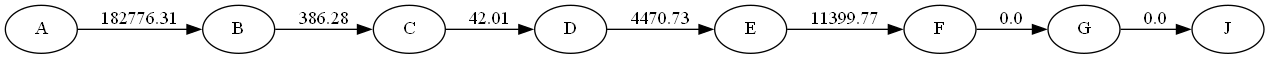

In [58]:
Image(avg_pt_wt_graph.create_png())

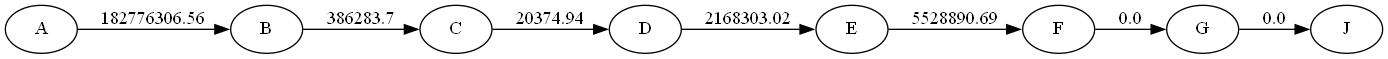

In [59]:
Image(total_pt_wt_graph.create_png())

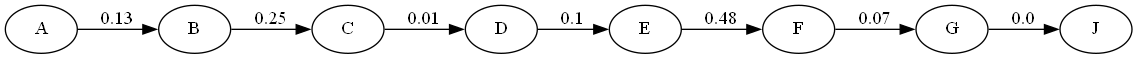

In [60]:
Image(avg_freq_graph.create_png())

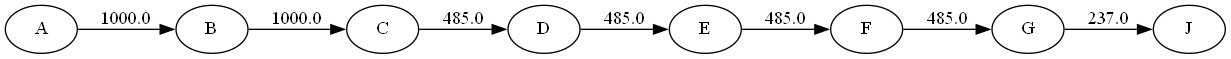

In [61]:
Image(total_freq_graph.create_png())